# Line Follower - CompRobo17

This notebook will show the general procedure to use our project data directories and how to do a regression task using convnets

## Imports and Directories

In [1]:
#Create references to important directories we will use over and over
import os, sys
DATA_HOME_DIR = '/home/nathan/olin/spring2017/line-follower/line-follower/data'

In [2]:
#import modules
import numpy as np
from glob import glob
from PIL import Image
from tqdm import tqdm


from keras.models import Sequential
from keras.metrics import categorical_crossentropy, categorical_accuracy
from keras.layers.convolutional import *
from keras.preprocessing import image
from keras.layers.core import Flatten, Dense
from keras.optimizers import Adam

from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

Using TensorFlow backend.


In [3]:
%cd $DATA_HOME_DIR

#Set path to sample/ path if desired
path = DATA_HOME_DIR
train_path=path + '/sun_apr_16_office_full_line_1'
valid_path=path + '/sun_apr_16_office_full_line_2'

/home/nathan/olin/spring2017/line-follower/line-follower/data


## Helper Functions

In [4]:
def folder_to_numpy(image_directory_full):
    """
    Read sorted pictures (by filename) in a folder to a numpy array
    
    USAGE:
        data_folder = '/train/test1'
        X_train = folder_to_numpy(data_folder)
    
    Args:
        data_folder (str): The relative folder from DATA_HOME_DIR
        
    Returns:
        picture_array (np array): The numpy array in tensorflow format
    """
    # change directory
    print ("Moving to directory: " + image_directory_full)
    os.chdir(image_directory_full)
    
    # read in filenames from directory
    g = glob('*.png')
    if len(g) == 0:
        g = glob('*.jpg')
    print ("Found {} pictures".format(len(g)))
    
    # sort filenames
    g.sort()
    
    # open and convert images to numpy array
    print("Starting pictures to numpy conversion")
    picture_arrays = np.array([np.array(Image.open(image_path)) for image_path in g])
    
#     reshape to tensorflow format
#     picture_arrays = picture_arrays.reshape(*picture_arrays.shape, 1)
    print ("Shape of output: {}".format(picture_arrays.shape))
    
    # return array
    return picture_arrays
    return picture_arrays.astype('float32')

In [5]:
def flip4DArray(array):
    """ Produces the mirror images of a 4D image array """
    return array[..., ::-1,:] #[:,:,::-1] also works but is 50% slower

## Data

Because we are using a CNN and unordered pictures, we can flip our data and concatenate it on the end of all training and validation data

### Training Data

In [6]:
%cd $train_path
Y_train = np.genfromtxt('cmd_vel.csv', delimiter=',')[:,1] # only use turning angle
Y_train = np.concatenate((Y_train, Y_train*-1)) # multiply by negative 1 for opposite turn
X_train = folder_to_numpy(train_path + '/raw')
X_train = np.concatenate((X_train, flip4DArray(X_train)))

/home/nathan/olin/spring2017/line-follower/line-follower/data/sun_apr_16_office_full_line_1
Moving to directory: /home/nathan/olin/spring2017/line-follower/line-follower/data/sun_apr_16_office_full_line_1/raw
Found 286 pictures
Starting pictures to numpy conversion
Shape of output: (286, 480, 640, 3)


In [8]:
X_train.shape, Y_train.shape

((572, 480, 640, 3), (572,))

/tmp


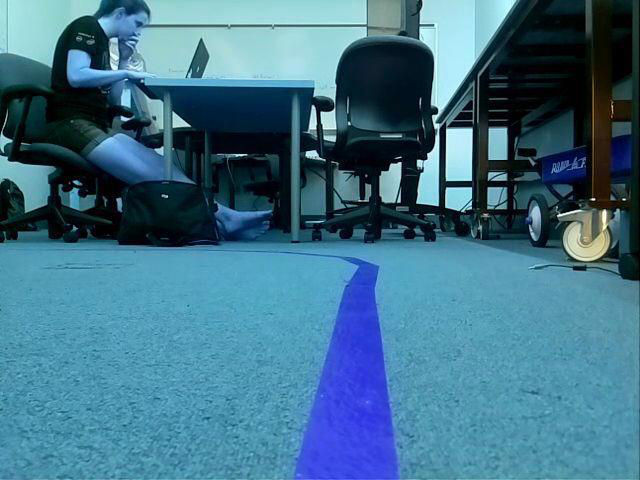

In [9]:
%cd /tmp
img = Image.fromarray(X_train[0], 'RGB')
img.save("temp.jpg")
image.load_img("temp.jpg")

### Validation Data

In [7]:
%cd $valid_path
Y_valid = np.genfromtxt('cmd_vel.csv', delimiter=',')[:,1]
Y_valid = np.concatenate((Y_valid, Y_valid*-1))
X_valid = folder_to_numpy(valid_path + '/raw')
X_valid = np.concatenate((X_valid, flip4DArray(X_valid)))

/home/nathan/olin/spring2017/line-follower/line-follower/data/sun_apr_16_office_full_line_2
Moving to directory: /home/nathan/olin/spring2017/line-follower/line-follower/data/sun_apr_16_office_full_line_2/raw
Found 130 pictures
Starting pictures to numpy conversion
Shape of output: (130, 480, 640, 3)


In [10]:
X_valid.shape, Y_valid.shape

((260, 480, 640, 3), (260,))

## Convnet

### Constants

In [11]:
from scipy.ndimage import zoom

In [12]:
def resize_vectorized4D(data, new_size=(64, 64)):
    fy, fx = np.asarray(new_size, np.float32) / data.shape[1:3]
    return zoom(data, (1, fy, fx, 1), order=1)

In [13]:
img_rows, img_cols = (32, 32)
in_shape = (img_rows, img_cols, 3)
batch_size = 1

In [14]:
print(img_rows)
print(img_cols)
print(in_shape)

32
32
(32, 32, 3)


In [15]:
X_train = resize_vectorized4D(X_train, (img_rows, img_cols))

In [16]:
X_valid = resize_vectorized4D(X_valid, (img_rows, img_cols))

In [17]:
print(X_train.shape)
print(X_valid.shape)

(572, 32, 32, 3)
(260, 32, 32, 3)


### Batches

In [18]:
gen = image.ImageDataGenerator(
#                                 rescale=1. / 255 # normalize data between 0 and 1
                              )

In [19]:
train_generator = gen.flow(X_train, Y_train, batch_size=32, shuffle=True)
valid_generator = gen.flow(X_valid, Y_valid, batch_size=32, shuffle=True)

# get_batches(train_path, batch_size=batch_size, 
#                             target_size=in_shape, 
#                             gen=gen)
# val_batches   = get_batches(valid_path, batch_size=batch_size, 
#                             target_size=in_shape, 
#                             gen=gen)

In [20]:
data, category = next(train_generator)
data.shape

(32, 32, 32, 3)

/tmp


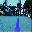

In [21]:
%cd /tmp
img = Image.fromarray(X_train[0], 'RGB')
img.save("temp.jpg")
image.load_img("temp.jpg")

### Model

In [22]:
def get_model():
    model = Sequential([
        Convolution2D(32,3,3, border_mode='same', activation='relu', input_shape=in_shape),
        MaxPooling2D(),
        Convolution2D(64,3,3, border_mode='same', activation='relu'),
        MaxPooling2D(),
        Flatten(),
        Dense(1024, activation='relu'),
        Dense(1)
        ])
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

In [23]:
model = get_model()

In [24]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
convolution2d_1 (Convolution2D)  (None, 32, 32, 32)    896         convolution2d_input_1[0][0]      
____________________________________________________________________________________________________
maxpooling2d_1 (MaxPooling2D)    (None, 16, 16, 32)    0           convolution2d_1[0][0]            
____________________________________________________________________________________________________
convolution2d_2 (Convolution2D)  (None, 16, 16, 64)    18496       maxpooling2d_1[0][0]             
____________________________________________________________________________________________________
maxpooling2d_2 (MaxPooling2D)    (None, 8, 8, 64)      0           convolution2d_2[0][0]            
___________________________________________________________________________________________

### Train

In [39]:
model.fit_generator(train_generator, 
                    samples_per_epoch=train_generator.n,
                    nb_epoch=30,
                    validation_data=valid_generator,
                    nb_val_samples=valid_generator.n,
                    verbose=True)

Epoch 1/30
572/572 [==============================] - 0s - loss: 5.4188e-04 - val_loss: 4.8593e-04
Epoch 2/30
572/572 [==============================] - 0s - loss: 6.1740e-04 - val_loss: 0.0038
Epoch 3/30
572/572 [==============================] - 0s - loss: 5.8989e-04 - val_loss: 0.0038
Epoch 4/30
572/572 [==============================] - 0s - loss: 7.7045e-04 - val_loss: 0.0038
Epoch 5/30
572/572 [==============================] - 0s - loss: 9.8303e-04 - val_loss: 0.0013
Epoch 6/30
572/572 [==============================] - 0s - loss: 0.0014 - val_loss: 0.0078
Epoch 7/30
572/572 [==============================] - 0s - loss: 0.0011 - val_loss: 0.0055
Epoch 8/30
572/572 [==============================] - 0s - loss: 0.0015 - val_loss: 0.0041
Epoch 9/30
572/572 [==============================] - 0s - loss: 0.0014 - val_loss: 0.0042
Epoch 10/30
572/572 [==============================] - 0s - loss: 0.0019 - val_loss: 0.0073
Epoch 11/30
572/572 [==============================] - 0s - loss:

In [ ]:
# model.save_weights('binary_86.h5')